In [5]:
import requests
import pickle
# Set up the API call variables
game_data = []
error_id = []
year = '2021'
season_type = '02' 
max_game_ID = 100

In [6]:
# Loop over the counter and format the API call
for i in range(0,max_game_ID):
    game_ID = year + season_type +str(i).zfill(4)
    try:
        r = requests.get(url='http://statsapi.web.nhl.com/api/v1/game/'+ game_ID +'/feed/live', 
                         timeout=5)
        data = r.json()
        game_data.append(data)
        # print('Finished ID', game_ID)
    except:
        error_id.append(game_ID)

In [7]:
len(game_data)

100

In [8]:
with open('./FullDataset.pkl', 'wb') as f:
    pickle.dump(game_data, f, pickle.HIGHEST_PROTOCOL)

In [3]:
import numpy as np 
import pandas as pd 
import pickle    
import matplotlib
import matplotlib.pyplot as plt
color_map = plt.cm.winter
from matplotlib.patches import RegularPolygon
import math
from PIL import Image
# Needed for custom colour mapping!
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib.colors as mcolors

In [9]:
with open("./FullDataset.pkl", "rb") as f:
    game_data = pickle.load(f)

sample = game_data[2]

In [4]:
sample['gameData']['datetime']['dateTime'].split('-')

['2021', '10', '13T02:00:00Z']

In [11]:
event_types = ['Shot','Goal']

In [13]:
# event, x, y, team_o (offence team), team_d (defending team), period, player_o, year, month

master_data = []

for data in game_data:
    if 'liveData' not in data or 'gameData' not in data:
        continue
    
    teams = {
        "away": data['gameData']['teams']['away']['name'],
        "home": data['gameData']['teams']['home']['name']
    }
    teams_list = list(teams.values())
    plays = data['liveData']['plays']['allPlays']
    
    # Year and month of game
    date = data['gameData']['datetime']['dateTime'].split('-')
    year = date[0]
    month = date[1]
    
    for play in plays:
        for event in event_types:
            
            if play['result']['event'] in [event]:
                if 'x' in play['coordinates'] and 'y' in play['coordinates']:
                    x = play['coordinates']['x']
                    y = play['coordinates']['y']
                else: 
                    print('No coordinates')
                    continue
                
                TEAM = play['team']['name']
                if TEAM:
                    team_o = TEAM
                    team_d = teams_list[(teams_list.index(TEAM) + 1) % 2]
                else: 
                    print('No team name')
                    continue
                
                # period
                period = play['about']['period']
                
                # To get the players
                description = play['result']['description']
                if description:
                    player_o = ' '.join(description.strip().split()[:2])
                else: 
                    print('No description')
                    continue
                
                master_data.append([event, x, y, team_o, team_d, period, player_o, year, month])
                    

In [14]:
df = pd.DataFrame(master_data, columns=['event', 'x', 'y', 'team_o', 'team_d', 'period', 'player_o', 'year', 'month'])

In [15]:
df

,event,x,y,team_o,team_d,period,player_o,year,month
0,Shot,61.0,-32.0,Tampa Bay Lightning,Pittsburgh Penguins,1,Steven Stamkos,2021,10
1,Shot,-65.0,19.0,Pittsburgh Penguins,Tampa Bay Lightning,1,Brock McGinn,2021,10
2,Shot,-8.0,-27.0,Tampa Bay Lightning,Pittsburgh Penguins,1,Jan Rutta,2021,10
3,Shot,-60.0,-4.0,Pittsburgh Penguins,Tampa Bay Lightning,1,Danton Heinen,2021,10
4,Shot,63.0,4.0,Tampa Bay Lightning,Pittsburgh Penguins,1,Ondrej Palat,2021,10
...,...,...,...,...,...,...,...,...,...
6198,Shot,68.0,10.0,Chicago Blackhawks,Toronto Maple Leafs,4,Brandon Hagel,2021,10
6199,Shot,-50.0,15.0,Toronto Maple Leafs,Chicago Blackhawks,4,Mitchell Marner,2021,10
6200,Shot,-58.0,24.0,Toronto Maple Leafs,Chicago Blackhawks,4,John Tavares,2021,10
6201,Shot,69.0,5.0,Chicago Blackhawks,Toronto Maple Leafs,4,Seth Jones,2021,10


In [8]:
df['team_o'].unique()

array(['Tampa Bay Lightning', 'Pittsburgh Penguins', 'Seattle Kraken',
       'Vegas Golden Knights', 'Montréal Canadiens',
       'Toronto Maple Leafs', 'New York Rangers', 'Washington Capitals',
       'Colorado Avalanche', 'Chicago Blackhawks', 'Vancouver Canucks',
       'Edmonton Oilers', 'Buffalo Sabres', 'Ottawa Senators',
       'Detroit Red Wings', 'Florida Panthers', 'Dallas Stars',
       'New York Islanders', 'Carolina Hurricanes',
       'Columbus Blue Jackets', 'Arizona Coyotes', 'Nashville Predators',
       'Winnipeg Jets', 'Anaheim Ducks', 'Los Angeles Kings',
       'New Jersey Devils', 'Philadelphia Flyers', 'Minnesota Wild',
       'Boston Bruins', 'St. Louis Blues', 'Calgary Flames',
       'San Jose Sharks'], dtype=object)

In [17]:
coors = df[ (df['team_d'] == 'Tampa Bay Lightning') & (df['event'] == 'Goal') ][['x', 'y']]

In [18]:
coors

,x,y
21,74.0,-9.0
23,72.0,2.0
48,-52.0,29.0
55,-63.0,14.0
58,31.0,32.0
59,24.0,10.0
553,-86.0,1.0
560,64.0,3.0
569,85.0,-1.0
574,82.0,8.0


In [51]:
mask = (coors.x < 0).values

mask_values = mask.astype(np.int64)

In [52]:
y_mask = np.where(mask_values == 0, 1, -1)

In [53]:
coors.y * y_mask

21      -9.0
23       2.0
48     -29.0
55     -14.0
58      32.0
59      10.0
553     -1.0
560      3.0
569     -1.0
574      8.0
591    -10.0
595     -0.0
1709    -2.0
2629   -27.0
2646    -2.0
2658   -14.0
2662   -20.0
4260    -1.0
4283   -18.0
4301    29.0
4316    -2.0
4318    -0.0
4319     2.0
5187   -11.0
5220     6.0
5226    -4.0
5237   -33.0
5242    22.0
5745     2.0
Name: y, dtype: float64

In [54]:
def y_coor_aug(df):
    mask_values = (df.x < 0).values.astype(np.int64)
    return np.where(mask_values == 0, 1, -1)
    

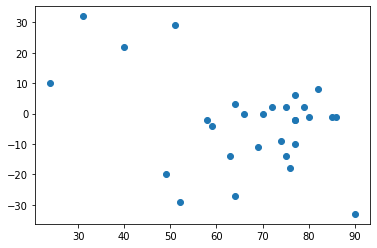

In [144]:
y_mask = y_coor_aug(coors)
x = coors.x.abs()
y = coors.y * y_mask


plt.scatter(x, y)
plt.show()

In [145]:
from PIL import Image, ImageOps

image_file = "Hockey-field-half.png"
image = Image.open(image_file).resize((400,340))
image_arr = np.array(image.getdata())

In [146]:
image_arr = image_arr.reshape(image.size[1], image.size[0], 4)

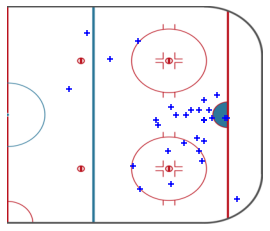

In [156]:
plt.imshow(image_arr, extent=[0,100, -42.5, 42.5])
plt.scatter(x, y, marker="+", color="blue")

ax = plt.gca() #get current axes

#hide x-axis
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.spines[["right", 'left', "top", "bottom"]].set_visible(False)
# plt.show()

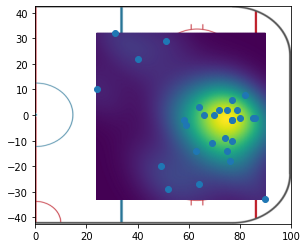

In [158]:
from scipy.stats import kde # https://www.python-graph-gallery.com/85-density-plot-with-matplotlib

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='Gouraud')
plt.scatter(x, y)
plt.imshow(image_arr, extent=[0,100, -42.5, 42.5])


plt.show()